In [1]:
# Import des packages
import numpy as np
from numpy import linalg as lg
from matplotlib import pyplot as plt
from scipy.integrate import quad, solve_ivp, odeint
from scipy import misc, optimize
from numpy import sinh, sin, cosh, cos, exp, pi,log
import scipy.stats as sc

## Résolution de l'équation du pont

$$ \partial_x^4 u + \gamma u = f $$
$$ u(\pm\pi)=u(\pm a\pi)=u''(\pm\pi)= 0 $$

avec $$ f \in L^2(I) $$

$$ \gamma > 0, a\in \left]0,1\right[ $$

$$ I = ]-\pi,\pi[, \partial I = \{\pm\pi,\pm a\pi\}$$

### Schéma du pont ###

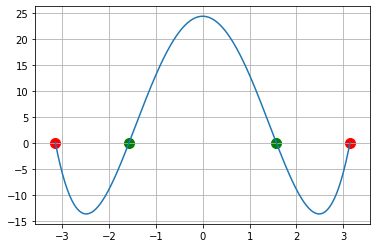

In [2]:
a=1/2
x=np.linspace(-pi,pi,500)
plt.plot(x,(x-a*pi)*(x+a*pi)*(x-pi)*(x+pi))
for i in [-pi,pi]     : plt.scatter(i,0,color='r',marker="o",s=100)
for i in [-a*pi,a*pi] : plt.scatter(i,0,color='green',marker="o",s=100)
plt.grid()

##### Solution pour  $\gamma=0$

In [3]:
def integrale(f,b1,b2) : return quad(f,b1,b2)[0]
def integrale_mult(f,b1,b2,o) :
    if o == 1 : return integrale(f,b1,b2)
    else : return integrale(lambda x : integrale_mult(f,b1,x,o-1),b1,b2)

def F4(f,y) :
    return integrale_mult(f,-pi,y,4)

def F2(f,y) :
    return integrale_mult(f,-pi,y,2)

def u(a,x) : return 1/360*(x**2-pi**2)*(x**2-a**2*pi**2)*(x**2-31/19 * pi**2)

f=lambda x:x**2
f2=lambda x:x**2-73*pi**2 /380
def f3(x):
    res = 50-500*(x+pi/2-0.1)**2
    if res>0 : return res
    else : return 0
f4=lambda x:(x+1)**2

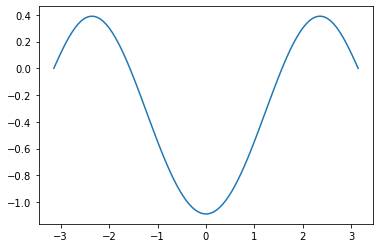

In [4]:
x1 = np.linspace(-pi,pi,100)
plt.plot(x1,list(map(lambda x : u(1/2,x),x1)))

In [5]:
print("valeur calculée   valeur théorique     erreur")
print()
print((2*F2(f,pi)*pi**2 - 3*F4(f,pi))/(6.*pi),pi**5/15,(2*F2(f,pi)*pi**2 - 3*F4(f,pi))/(6.*pi)-pi**5/15)
print(-F2(f,pi)/(2.*pi),-pi**3/3,-F2(f,pi)/(2.*pi)+pi**3/3)

valeur calculée   valeur théorique     erreur

20.401312319018754 20.40131231901876 -7.105427357601002e-15
-10.335425560099939 -10.335425560099939 0.0


### Paramètres maillage

In [6]:
# Maillage
def x_ab_const(a,n):
    n1=n[0] # Nombre de points internes de chaque tablier latéral
    n2=n[1] # Nombre de points internes du tablier central (principal)
    n3=n[2]
    
    x1 = np.linspace(-pi,-a*pi,n1+2)
    x2 = np.linspace(-a*pi,a*pi,n2+2)
    x3 = np.linspace(a*pi,pi,n3+2)

    x_avec_bord = np.concatenate((x1[:-1],x2,x3[1:]))

    return x_avec_bord

def x_sb_const(a,n):
    n1=n[0] # Nombre de points internes de chaque tablier latéral
    n2=n[1] # Nombre de points internes du tablier central (principal)
    n3=n[2]
    
    x1 = np.linspace(-pi,-a*pi,n1+2)
    x2 = np.linspace(-a*pi,a*pi,n2+2)
    x3 = np.linspace(a*pi,pi,n3+2)

    x_sans_bord = np.concatenate((x1[1:-1],x2[1:-1],x3[1:-1]))

    return x_sans_bord
#x_sbsp = np.concatenate((x1[1:-1],x2[1:-1],x3[1:-1]))
#x_sans_bord = x_avec_bord[1:-1]

#t1=0 # intervalle temporel borne 1
#t2=50 # intervalle temporel borne 2
#m=60 # Nombre de points internes (temps)
#dt=(t2-t1)/(m+1) # Pas de discrétisation spatial
#coor_t = np.linspace(t1,t2,m+2)

## Méthode des différences finies

In [7]:
def mdf(tab_n,a,γ,g):
    
    x_ab=x_ab_const(a,tab_n)
    x_sb=x_sb_const(a,tab_n)
    
    n1=tab_n[0]
    n2=tab_n[1]
    n3=tab_n[2]
    N=np.sum(tab_n)

# Matrice
    
    M1 = np.zeros((n1,n1))
    M2 = np.zeros((n2,n2))
    M3 = np.zeros((n3,n3))
    M  = np.zeros((N,N))

    dx1=x_ab[1]-x_ab[0]
    dx2=x_ab[n1+n2+2]-x_ab[n1+n2+1]
    dx3=x_ab[N+3]-x_ab[N+2]


    M1 = M1 + 1*(np.diag(np.ones(n1-2),-2) + np.diag(np.ones(n1-2),2))
    M1 = M1 - 4*(np.diag(np.ones(n1-1),-1) + np.diag(np.ones(n1-1),1))
    M1 = M1 + 6*np.diag(np.ones(n1),0)

    M1 = M1 + γ * dx1**4 * np.eye(n1)

    M1[0] = np.zeros(n1)
    M1[-1] = np.zeros(n1)

    M1 = 1/dx1**4 * M1


    M2 = M2 + 1*(np.diag(np.ones(n2-2),-2) + np.diag(np.ones(n2-2),2))
    M2 = M2 - 4*(np.diag(np.ones(n2-1),-1) + np.diag(np.ones(n2-1),1))
    M2 = M2 + 6*np.diag(np.ones(n2),0)

    M2 = M2 + γ * dx2**4 * np.eye(n2)

    M2[0] = np.zeros(n2)
    M2[-1] = np.zeros(n2)

    M2 = 1/dx2**4 * M2


    M3 = M3 + 1*(np.diag(np.ones(n3-2),-2) + np.diag(np.ones(n3-2),2))
    M3 = M3 - 4*(np.diag(np.ones(n3-1),-1) + np.diag(np.ones(n3-1),1))
    M3 = M3 + 6*np.diag(np.ones(n3),0)

    M3 = M3 + γ * dx3**4 * np.eye(n3)

    M3[0]  = np.zeros(n3)
    M3[-1] = np.zeros(n3)

    M3 = 1/dx3**4 * M3

    #print(M1,M2,M3)

    M[0:n1,0:n1]         = M1
    M[n1:n1+n2,n1:n1+n2] = M2
    M[n1+n2:,n1+n2:]     = M3

    M[0,:2]=[2,-1]
    M[-1,-2:]=[-1,2]
    M[n1-1,n1-1:n1+1]=[dx2,dx1]
    M[n1,n1-2:n1+2]=[dx2**2,-2*dx2**2,2*dx1**2,-dx1**2]
    M[n1+n2-1,n1+n2-1:n1+n2+1]=[dx3,dx2]
    M[n1+n2,n1+n2-2:n1+n2+2]=[dx3**2,-2*dx3**2,2*dx2**2,-dx2**2]

    # Second membre

    #def u0(x) : return x**2
    F=list(map(g,x_sb))
    for i in [0,n1-1,n1,n1+n2-1,n1+n2,-1] : F[i]=0
        
    # Résolution 
    
    U = lg.solve(M,F)

    U_fin = np.zeros(N+4)
    U_fin[1:n1+1] = U[:n1]
    U_fin[n1+2:n1+n2+2] = U[n1:n1+n2]
    U_fin[n1+n2+3:N+3] = U[n1+n2:]
    
    return U_fin,x_ab,M

def snd_f(U,x):
    res=0
    v=U[0]
    x_ab=U[1]
    i=0
    while x_ab[i]<=x: i=i+1
    res=(v[i-1]-v[i])/(x_ab[i-1]-x_ab[i])*(x-x_ab[i])+v[i]
    return res

def tracer_erreur(methode,solution_exacte,a,γ,g) :
    tailles = [40,80,120,240,1200,2000,4000]
    erreurs = np.zeros(np.size(tailles))
    erreurs_l2 = np.zeros(np.size(tailles))
    erreurs_h10 = np.zeros(np.size(tailles))
    
    i2_ex = integrale(lambda x : solution_exacte(x)**2,-pi,pi)    
    
    for k in range(np.size(tailles)) :
        t1=tailles[k]//4
        t2=2*t1
        snd = methode([t1,t2,t1],a,γ,g) #solution numérique discrétisée
        x_ab=snd[1]
        U=snd[0]
        
        snd_fonc=lambda x:snd_f(snd,x)
        i2_me=integrale(lambda x : snd_fonc(x)**2,-pi,pi)

        prod_fonc=lambda x : snd_fonc(x)*solution_exacte(x)
        i_prod=integrale(prod_fonc,-pi,pi)
        
        erreurs[k] = i2_ex+i2_me-2*i_prod
        
    log_tailles = list(map(log,tailles))
    log_erreurs = list(map(log,erreurs))
        
    #Regression
    droite = sc.linregress(log_tailles,log_erreurs)
    log_erreurs_linearise = list(map(lambda x : droite.slope*x+droite.intercept,log_tailles))
    
    #Légende
    plt.plot(log_tailles,log_erreurs, '*') #Tracé des log(erreurs) en fonction de log(n)
    plt.plot(log_tailles, log_erreurs_linearise, 'r') #Tracé du linéarisé
    plt.xlabel('log(n)')
    plt.ylabel('log(err)')
    plt.show()
    
    print("coefficient directeur : ", droite.slope)
    print("ordonnée à l'origine  : ", droite.intercept)

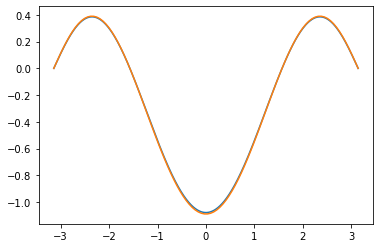

In [8]:
u_mdf=mdf([300,600,300],1/2,0,f2)
plt.plot(u_mdf[1],u_mdf[0])

x1 = np.linspace(-pi,pi,100)
plt.plot(x1,list(map(lambda x : u(1/2,x),x1)))

<ipython-input-3-515ef9d11bd0>:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  def integrale(f,b1,b2) : return quad(f,b1,b2)[0]
<ipython-input-3-515ef9d11bd0>:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  def integrale(f,b1,b2) : return quad(f,b1,b2)[0]


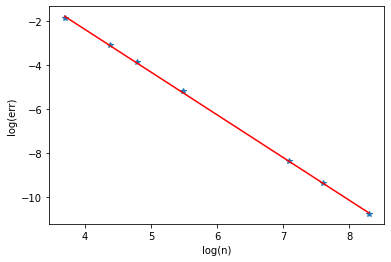

coefficient directeur :  -1.9442924081558606
ordonnée à l'origine  :  5.40702627577487


In [9]:
tracer_erreur(mdf,lambda x : u(1/2,x),1/2,0,f2)

## Méthode des éléments finis

## Fonctions de base MEF (P3)

In [10]:
def φ1(x) : 
    if -1<=x and x<=0 : return -2*x**3 - 3*x**2 + 1
    else : return 0
def φ2(x) : 
    if 0<=x and x<=1 : return 2*x**3 - 3*x**2 + 1
    else : return 0

def ψ1(x) : 
    if -1<=x and x<=0 : return x**3 + 2*x**2 + x
    else : return 0
def ψ2(x) : 
    if 0<=x and x<=1 : return x**3 - 2*x**2 + x
    else : return 0
    

def φ(x,i,x_ab,n) :
    
    n1=n[0]
    n2=n[1]
    n3=n[2]
    N=np.sum(n)
    
    if 1<=i and i!=n1+1 and i!=n1+n2+2 and i<=N+2 :
        h1 = x_ab[i]-x_ab[i-1]
        h2 = x_ab[i+1]-x_ab[i]
        y = x-x_ab[i]
        
        if -h1<y and y<=0 : return φ1(y/h1)
        else :
            if  0<y and y<=h2 : return φ2(y/h2)
            else : return 0
    
    else : return 0
            
def ψ(x,i,x_ab,n) :
    n1=n[0]
    n2=n[1]
    n3=n[2]
    N=np.sum(n)
    
    if i==0 :
        h=x_ab[1]-x_ab[0]
        y=(x-x_ab[0])/h
        
        return h*ψ2(y)
    
    else :
        if 1<=i and i<=N+2 :
            h1 = x_ab[i]-x_ab[i-1]
            h2 = x_ab[i+1]-x_ab[i]
            y = x-x_ab[i]

            if -h1<y and y<=0 : return h1*ψ1(y/h1)
            else :
                if  0<y and y<=h2 : return h2*ψ2(y/h2)
                else : return 0
            
        else :
            if i==N+3 :
                h=x_ab[N+3]-x_ab[N+2]
                y=(x-x_ab[N+2])/h

                return h*ψ2(1-y)

def θ(x,i,x_ab,n) :
    
    n1=n[0]
    n2=n[1]
    n3=n[2]
    N=np.sum(n)
    
    if i==0 : return ψ(x,i,x_ab,n)
    
    if 1<=i and i<=2*n1 :
        if i%2==1 : return φ(x,(i+1)//2,x_ab,n)
        else : return ψ(x,i//2,x_ab,n)
    
    if i==2*n1+1 : return ψ(x,(i+1)//2,x_ab,n)
    
    if 2*n1+2<=i and i<=2*(n1+n2)+1 :
        j=i+1
        if j%2==1 : return φ(x,(j+1)//2,x_ab,n)
        else : return ψ(x,j//2,x_ab,n)
        
    if i==2*(n1+n2)+2 : return ψ(x,(i+2)//2,x_ab,n)   
    
    if 2*(n1+n2)+3<=i and i<=2*N+2 :
        j=i+2
        if j%2==1 : return φ(x,(j+1)//2,x_ab,n)
        else : return ψ(x,j//2,x_ab,n)
    
    if i==2*N+3 : return ψ(x,(i+3)//2,x_ab,n)

In [11]:
def mef(n,a,γ,g):
    nb_foncti=2*np.sum(n)+4
    x_ab=x_ab_const(a,n)
    
    n1=n[0]
    n2=n[1]
    n3=n[2]
    
    N=np.sum(n)
    
    h1=x_ab[1]-x_ab[0]
    h2=x_ab[n1+n2+2]-x_ab[n1+n2+1]
    h3=x_ab[N+3]-x_ab[N+2]
    
    M=np.zeros((nb_foncti,nb_foncti))
    R=np.zeros((nb_foncti,nb_foncti))
    B=np.zeros(nb_foncti)

    eps=0.0000001

    for i in range(nb_foncti) :
        B[i] = integrale(lambda t : g(t)*θ(t,i,x_ab,n),-pi,pi)#x_ab[max(i-3,0)],x_ab[min(i+3,nb_foncti)])
        for j in range(max(i-3,0),min(i+4,nb_foncti)) :
            M[i,j] = integrale(lambda x : θ(x,i,x_ab,n)*θ(x,j,x_ab,n),-pi,pi)
            R[i,j] = integrale(lambda t : misc.derivative(lambda x : θ(x,i,x_ab,n),t,n=2,dx=eps)*misc.derivative(lambda x : θ(x,j,x_ab,n),t,n=2,dx=eps),-pi,pi)
    
    A=R + γ*M
    
    U=lg.solve(A,B)
    
    return U,a,n

def U_fonc(x,v) :
    res=0
    u=v[0]
    a=v[1]
    n=v[2]
    nb_foncti=2*np.sum(n)+4
    x_ab=x_ab_const(a,n)
    for i in range(nb_foncti) :
        res+=u[i]*θ(x,i,x_ab,n)
    return res

<ipython-input-3-515ef9d11bd0>:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  def integrale(f,b1,b2) : return quad(f,b1,b2)[0]


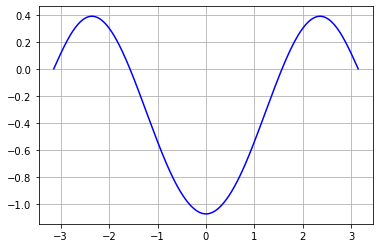

In [12]:
u_mef=mef([3,3,3],1/2,0,f2)
x = np.linspace(-pi,pi,500)
plt.plot(x,list(map(lambda t : U_fonc(t,u_mef),x)),color="blue")
plt.grid()

<ipython-input-3-515ef9d11bd0>:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  def integrale(f,b1,b2) : return quad(f,b1,b2)[0]


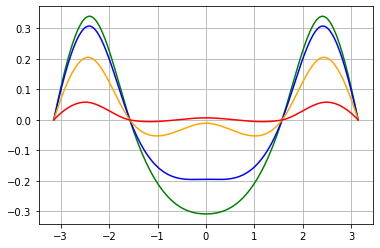

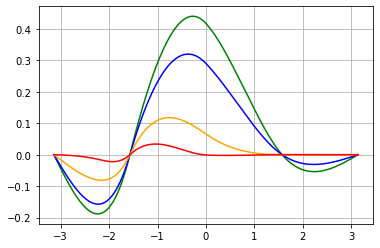

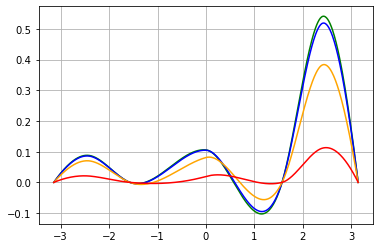

In [13]:
x = np.linspace(-pi,pi,500)
for i in [f,f3,f4]:
    for j in [0,1,10,100]:
        u_mef=mef([1,1,1],1/2,j,i)
        
        if j==0  : col="green"
        if j==1  : col="blue"
        if j==10 : col="orange"
        if j==100: col="red"
        
        plt.plot(x,list(map(lambda t : U_fonc(t,u_mef),x)),color=col)
        
    plt.grid()
    plt.show()



#x1 = np.linspace(-pi,pi,100)
#plt.plot(x1,list(map(lambda x : u(1/2,x),x1)))

## Déterminant Matrice - Eléments propres

In [14]:
def dm1(a,d) : return sin(pi*d)*sinh(a*pi*d)*sinh((1-a)*pi*d)-sinh(pi*d)*sin(a*pi*d)*sin((1-a)*pi*d)
def dm2(a,d) : return cos(pi*d)*cosh(a*pi*d)*sinh((1-a)*pi*d)-cosh(pi*d)*cos(a*pi*d)*sin((1-a)*pi*d)

def afficher(a,x1):
    
    print("a = ",a, "\nx1 = ",x1)

    g1 = lambda x : dm1(a,x)
    g2 = lambda x : dm2(a,x)
    
    eps = 0.0001
    t = np.linspace(x1-eps,x1+1+eps,200)
    
    plt.plot(t, np.zeros(np.size(t)), color="green")
    plt.plot(t, g1(t), color="blue")
    plt.plot(t, g2(t), color="red")
    #plt.plot(t, g1(t)*g2(t), color="orange")
    plt.ylim(-1,1)
    plt.grid()
    plt.show()

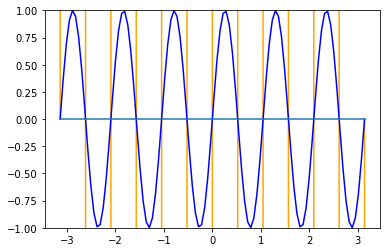

In [15]:
l=6
a=1/2

def O(x) : 
    #if isinstance(l,int) :
    #    return sin(l*x)
    #else : 
    if x<0 : return -O(-x)
    else : 
        if x<a*pi : return sinh(l*(1-a)*pi)*(sinh(l*a*pi)*sin(l*x)-sin(l*a*pi)*sinh(l*x))/sinh(l*a*pi)
        if x>a*pi : return sin(l*a*pi)*(sin(l*(1-a)*pi)*sinh(l*(pi-x))-sinh(l*(1-a)*pi)*sin(l*(pi-x)))/sin(l*(1-a)*pi)

def E(x) :
    if x<0 : return E(-x)
    else :
        if x<a*pi : return sinh(l*(1-a)*pi)*(cosh(l*a*pi)*cos(l*x)-cos(l*a*pi)*cosh(l*x))/cosh(l*a*pi)
        if x>a*pi : return cos(l*a*pi)*(sin(l*(1-a)*pi)*sinh(l*(x-pi))-sinh(l*(1-a)*pi)*sin(l*(x-pi)))/sin(l*(1-a)*pi)


x=np.linspace(-pi,pi,100)

if isinstance(l,int) : 
    fp = O
    f = sin
else :
    fp = E
    f = cos

plt.plot(x,list(map(fp,x)),color="orange")
plt.plot(x,f(l*x),color="blue")
plt.ylim(-1,1)
plt.plot(x,np.zeros(np.size(x)))

a =  0.5 
x1 =  0


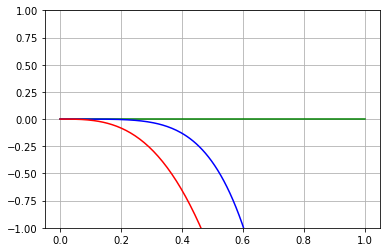

a =  0.5 
x1 =  1


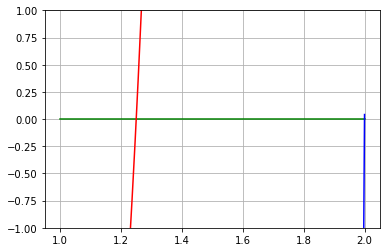

a =  0.5 
x1 =  2


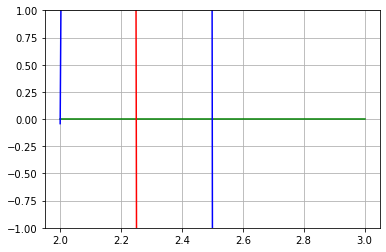

In [16]:
for j in range(3) : afficher(1/2,j)